In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.startswith("0"):
    PROJECT_ROOT = PROJECT_ROOT.parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%load_ext autoreload
%autoreload 2

In [2]:
# !pip install shap
# !pip install hyperopt
# !pip install loguru
# !pip install lightgbm

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Data Management
import yaml
import numpy as np
import pandas as pd

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier

# Opti
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from match_forecast.utils import *
from match_forecast.formatters import *

2025-04-23 18:48:22.288 | INFO     | match_forecast.config:<module>:11 - PROJ_ROOT path is: /Users/maichoun/QRT-Challenge-2024


In [4]:
PROJ_ROOT = Path("QRT-Challenge-2024").resolve().parents[1]
CONFIG_DIR = PROJ_ROOT / "config"
DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

In [5]:
try:
    train_data = pd.read_csv(PROCESSED_DATA_DIR / "train_data.csv", index_col=0)
    train_scores = pd.read_csv(RAW_DATA_DIR / "Y_train.csv", index_col=0)
    print("Files loaded")
    
except FileNotFoundError as e:
    print(e)

Files loaded


In [6]:
train_data.shape

(12303, 275)

In [7]:
train_scores = train_scores.loc[train_data.index]
train_scores_1c = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].idxmax(axis=1)
label_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
train_scores_1c = train_scores_1c.replace(label_mapping)

train_scores_1c.head(5)

ID
0    2
1    1
2    2
3    0
4    1
dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_scores_1c, train_size=0.8, random_state=42)

In [9]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 2000, 50),  
    'max_depth': hp.quniform('max_depth', 2, 30, 1),  
    'max_features': hp.uniform('max_features', 0.2, 0.8),
    'min_samples_split': hp.quniform('min_samples_split', 2, 50, 2),  
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),  
    'criterion': hp.choice('criterion', ['gini', 'entropy']),  
    'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample']),  
    'max_leaf_nodes': hp.quniform('max_leaf_nodes', 10, 1000, 10),  
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 0.5),  
}

In [10]:
n_splits = 3

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    params['max_leaf_nodes'] = int(params['max_leaf_nodes']) if params['max_leaf_nodes'] is not None else None

    max_features = params['max_features']
    if isinstance(max_features, float):  
        params['max_features'] = max_features
    elif isinstance(max_features, str):  
        params['max_features'] = max_features
    else:  
        params['max_features'] = None
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, valid_index in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        model = ExtraTreesClassifier(**params, random_state=42, n_jobs=-1)
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_valid_fold)
        accuracy = accuracy_score(y_valid_fold, y_pred)
        accuracies.append(accuracy)

    mean_loss = 1 - np.mean(accuracies)
    return {'loss': mean_loss, 'status': STATUS_OK}


In [11]:
train = False

if train:
    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=150, 
                trials=trials)

    print("Best hyperparameters:", best)

    results = [
        {
            **convert_numpy(trial['result']),
            'params': {key: convert_numpy(value[0]) if value else None for key, value in trial['misc']['vals'].items()}  # Convert hyperparameters
        }
        for trial in trials.trials
    ]

    raw_params = min(results, key=lambda x: x["loss"])['params']
    formatted_params = format_xt(raw_params)

    with open(CONFIG_DIR / "xt_params.yaml", "w") as f:
        yaml.dump(formatted_params, f)

In [12]:
with open(CONFIG_DIR / "xt_params.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [13]:
cfg

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 21,
 'max_features': 0.48300466724197205,
 'max_leaf_nodes': 580,
 'min_impurity_decrease': 0.0003126137488028501,
 'min_samples_leaf': 17,
 'min_samples_split': 16,
 'n_estimators': 750}

In [14]:
xt_model = ExtraTreesClassifier(
    **cfg,
    random_state=42,
    n_jobs=-1
)

xt_model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=21, max_features=0.48300466724197205,
                     max_leaf_nodes=580,
                     min_impurity_decrease=0.0003126137488028501,
                     min_samples_leaf=17, min_samples_split=16,
                     n_estimators=750, n_jobs=-1, random_state=42)

In [15]:
y_pred_final = xt_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Accuracy (test) : {final_accuracy * 100:.2f}%")

Accuracy (test) : 50.47%


In [16]:
importance_dict = dict(zip(
    X_train.columns,
    xt_model.feature_importances_
))

sorted_features = sorted(
    importance_dict.items(),
    key=lambda x: x[1],
    reverse=True
)
top_features = [feature for feature, score in sorted_features[:10]]

X_reduced = train_data[top_features]

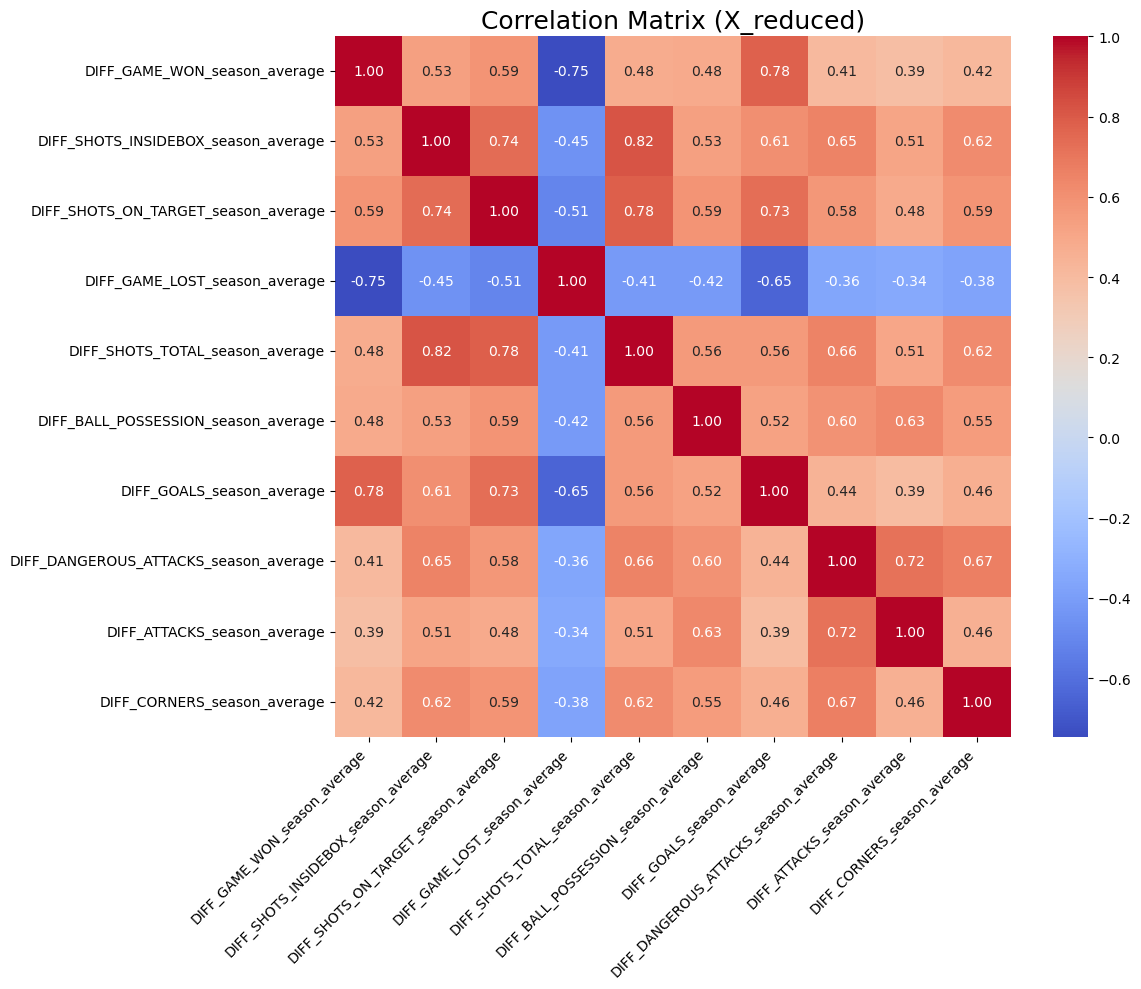

In [17]:
plot_correlation_matrix(X_reduced, title="Correlation Matrix (X_reduced)")

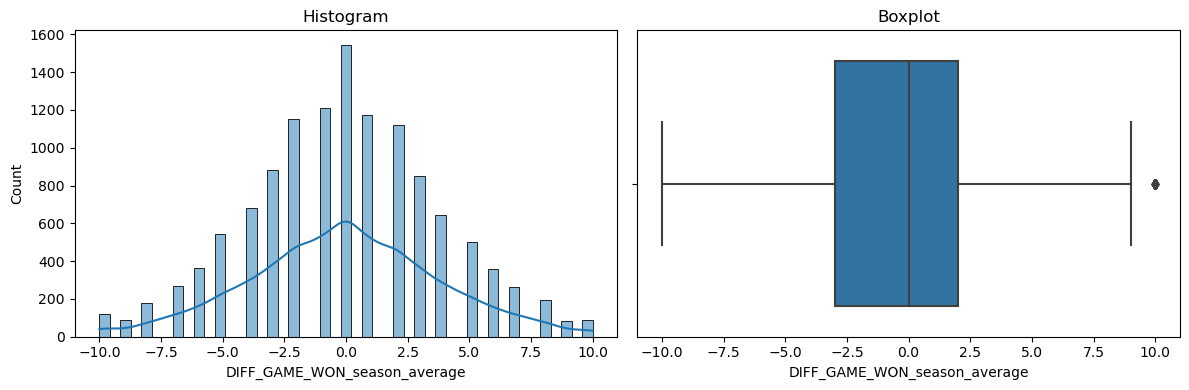

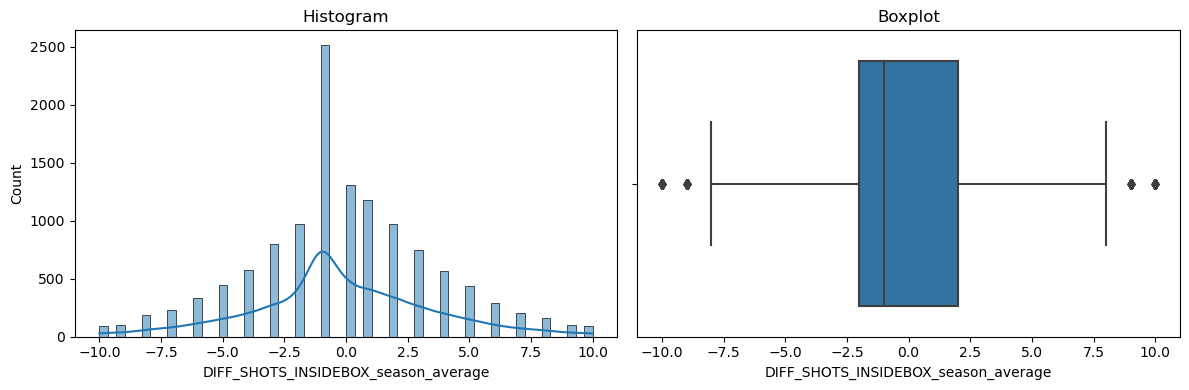

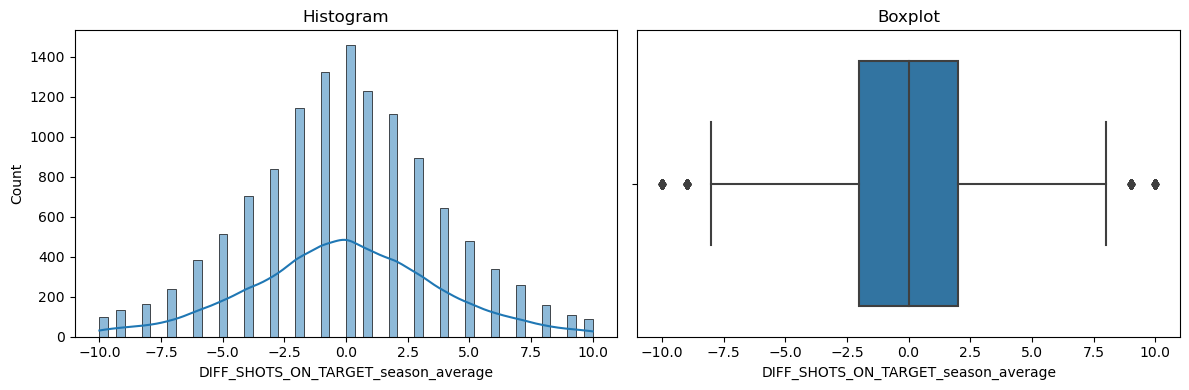

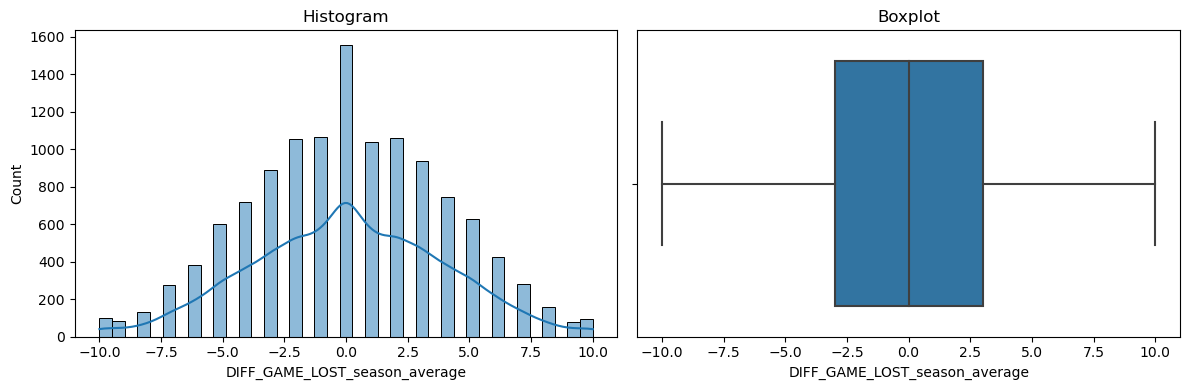

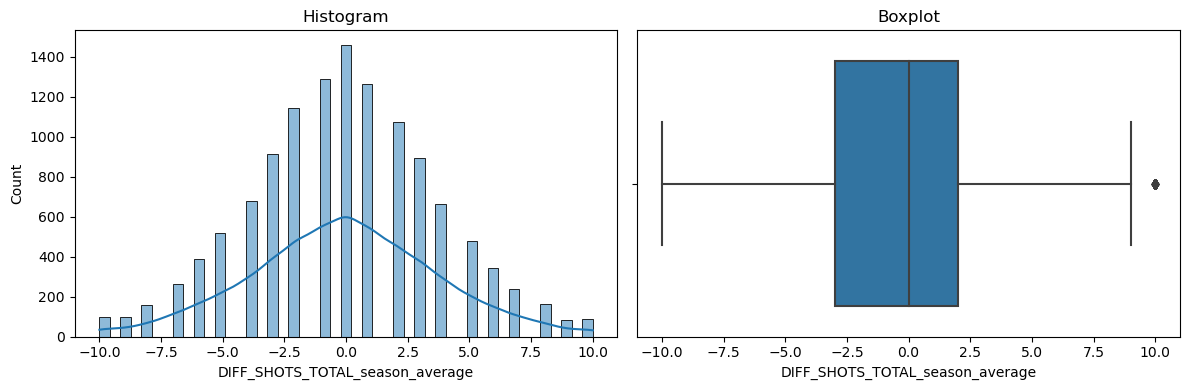

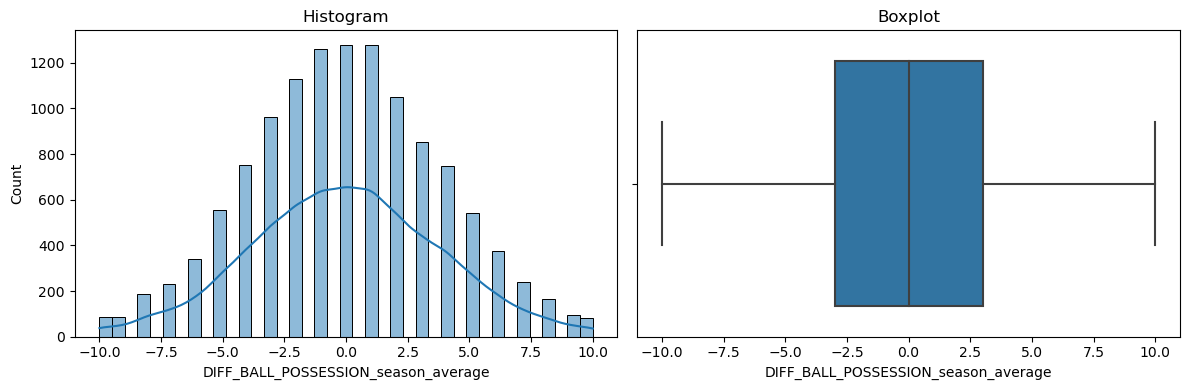

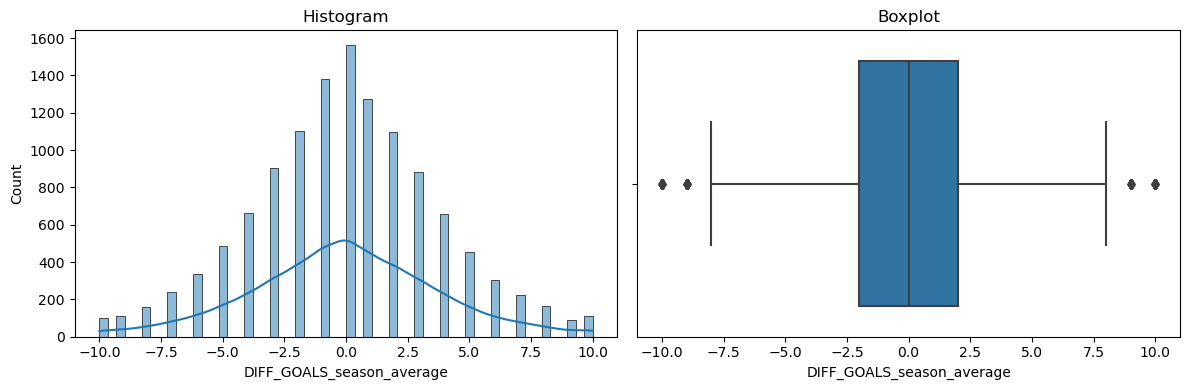

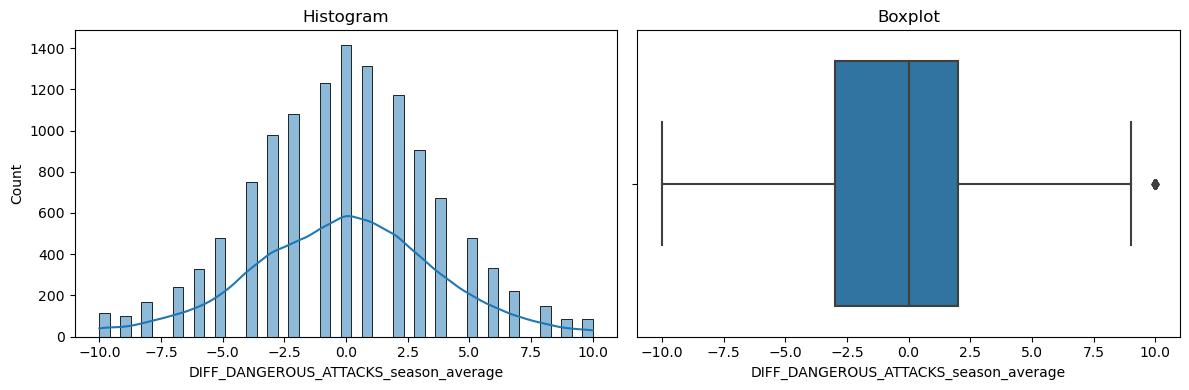

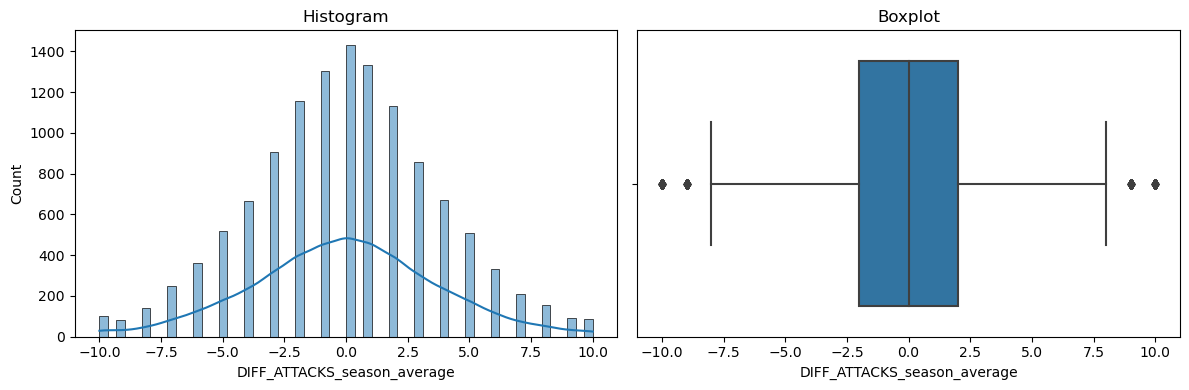

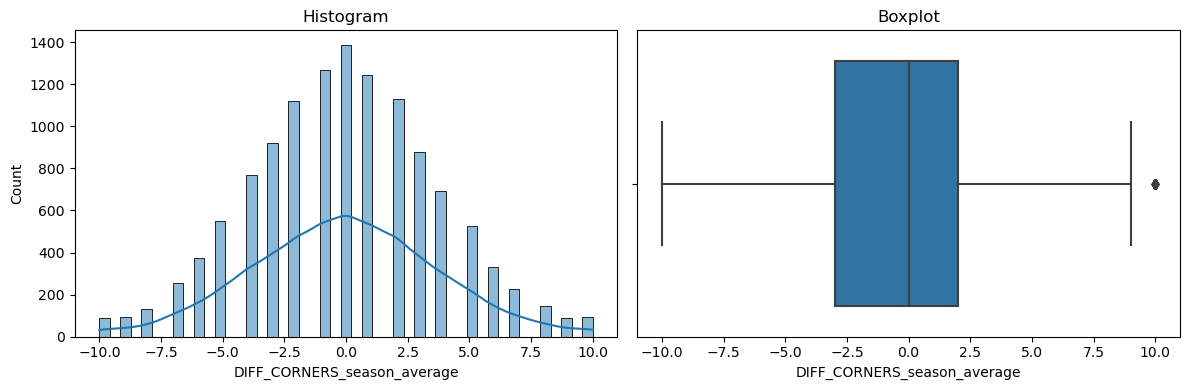

In [18]:
num_cols = X_reduced.select_dtypes(include=[np.number]).columns
cat_cols = X_reduced.select_dtypes(include=["object", "category"]).columns
plot_univariate_analysis(X_reduced, numeric_cols=num_cols, categorical_cols=cat_cols)